# 0.1 Import Requirements

Before we start, we need to import some libraries. You should be familiar with most of these. If not; don't worry they aren't too complicated, reading through this notebook should help you understand.

We are also going to set some options for our ```pandas``` library, so that we can scroll dataframes nicely.

In [221]:
import pandas as pd
import numpy as np

import pickle as p

import seaborn as sns
import matplotlib.pyplot as plt   

from sklearn.model_selection import train_test_split

from sklearn.compose import ColumnTransformer

from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler

from sklearn.impute import SimpleImputer

from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

pd.set_option('display.max_columns', 500)

# 0.2 Load Data

Let's load the data. The repository we are working in should contain a ```.csv``` file in the ```/code/data``` directory. 

I you can't find the file, feel free to download it from here: https://www.kaggle.com/datasets/jsphyg/weather-dataset-rattle-package?resource=download

In [179]:
# Loading a local csv file
data = '../data/weatherAUS.csv'

df = pd.read_csv(data)

# Convert column names to lowecase for convenience
df.columns = [x.lower() for x in df.columns]

# Dropping rows with a missing target variable
df = df.loc[df['raintomorrow'].notnull()]

In [180]:
# Making sure that there are no incorrectly assigned data types in the dataframe
df.dtypes

date              object
location          object
mintemp          float64
maxtemp          float64
rainfall         float64
evaporation      float64
sunshine         float64
windgustdir       object
windgustspeed    float64
winddir9am        object
winddir3pm        object
windspeed9am     float64
windspeed3pm     float64
humidity9am      float64
humidity3pm      float64
pressure9am      float64
pressure3pm      float64
cloud9am         float64
cloud3pm         float64
temp9am          float64
temp3pm          float64
raintoday         object
raintomorrow      object
dtype: object

In [181]:
# Converting date column to correct datetime format
df['date'] =  pd.to_datetime(df['date'], format='%Y-%m-%d')

Before we start our analysis, it is very important to split our data into a training and test set. Any insights we pick up, however small, should not be sourced from observations in the test set.

For this course we will use a 70/30 train/test split.

In [182]:
# Splitting data early to avoid data leakage
y = df['raintomorrow']
X = df.drop(columns=['raintomorrow'])

# Splitting in train and test set on 70/30 ratio
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123, shuffle=True)

# 1.0 Exploring the Data

First off, let's take a look at some random observations from the training set.

In [183]:
# Selecting 5 random observations to look at from the dataset.
X_train.sample(5, random_state=123)

,date,location,mintemp,maxtemp,rainfall,evaporation,sunshine,windgustdir,windgustspeed,winddir9am,winddir3pm,windspeed9am,windspeed3pm,humidity9am,humidity3pm,pressure9am,pressure3pm,cloud9am,cloud3pm,temp9am,temp3pm,raintoday
61160,2017-06-04,Bendigo,-0.9,13.5,0.2,NaN,NaN,W,20.0,NaN,WNW,0.0,11.0,98.0,53.0,1029.6,1026.3,NaN,NaN,4.4,13.2,No
73623,2013-10-08,Nhil,5.9,23.0,0.0,NaN,NaN,WSW,28.0,W,NNW,6.0,11.0,90.0,49.0,1019.2,1017.2,NaN,NaN,10.2,20.7,No
45964,2008-11-12,Canberra,11.1,30.4,0.0,7.8,11.6,ENE,39.0,E,WNW,2.0,11.0,59.0,19.0,1019.2,1014.9,5.0,3.0,18.4,28.9,No
28242,2012-01-11,Richmond,17.1,27.2,0.0,6.2,NaN,WSW,70.0,WNW,WSW,11.0,37.0,37.0,27.0,1004.6,1003.2,NaN,NaN,23.0,26.1,No
24112,2017-06-10,NorfolkIsland,14.8,19.1,28.4,NaN,NaN,SE,52.0,ESE,SE,24.0,26.0,65.0,62.0,1020.9,1020.1,8.0,1.0,17.9,18.3,Yes


In [184]:
X_train.columns

Index(['date', 'location', 'mintemp', 'maxtemp', 'rainfall', 'evaporation',
       'sunshine', 'windgustdir', 'windgustspeed', 'winddir9am', 'winddir3pm',
       'windspeed9am', 'windspeed3pm', 'humidity9am', 'humidity3pm',
       'pressure9am', 'pressure3pm', 'cloud9am', 'cloud3pm', 'temp9am',
       'temp3pm', 'raintoday'],
      dtype='object')

The dataset we are using seems to contain a wide variety of features, each with their own information. 

There is a mix of different types of data as well; date, numeric, categorical, boolean.

Let's take a look at some distributions and varaible interactions.

<AxesSubplot:ylabel='Frequency'>

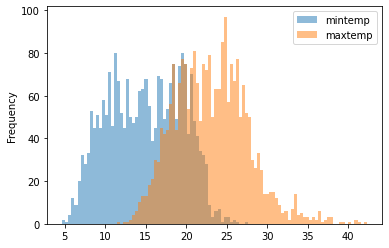

In [185]:
# Selecting a location and plotting some min and max temperatures.
X_train[(X_train.location == 'Sydney')][['mintemp', 'maxtemp']].plot.hist(alpha=0.5, bins=100)

<AxesSubplot:ylabel='Frequency'>

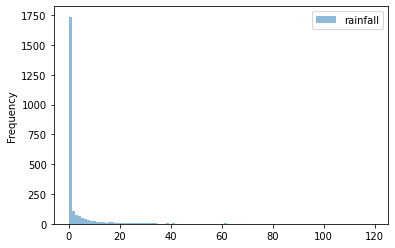

In [186]:
# Rainfall distribution is obviously very skewed...
X_train[(X_train.location == 'Sydney')][['rainfall']].plot.hist(alpha=0.5, bins=100)

<AxesSubplot:ylabel='Frequency'>

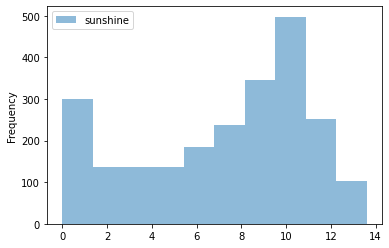

In [187]:
# .. and of course plenty of sunshine down under.
X_train[(X_train.location == 'Sydney')][['sunshine']].plot.hist(alpha=0.5, bins=10)

In [188]:
# Morning wind goes westward.
X_train[(X_train.location == 'Sydney')].winddir9am.value_counts(normalize=True)[:3]

W      0.370547
WNW    0.150738
SSW    0.054735
Name: winddir9am, dtype: float64

In [189]:
# Wind seems to change direction in the afternoon. Of course this is could vary by season.
X_train[(X_train.location == 'Sydney')].winddir3pm.value_counts(normalize=True)[:3]

E      0.181975
ENE    0.110824
NE     0.109530
Name: winddir3pm, dtype: float64

In [190]:
# In around 74% of Sydney's training set observations, it does not rain the next day.
y_train.loc[X_train[(X_train.location == 'Sydney')].index].value_counts(normalize=True)

No     0.736887
Yes    0.263113
Name: raintomorrow, dtype: float64

In [191]:
# It seems like Mildura caught the least amound of rainfall in 2017, while Darwin is more than 10 times as wet!
X_train[(X_train.date.dt.year == 2017)].groupby([X_train.location]).agg({'rainfall':np.mean}).sort_values('rainfall')

,rainfall
location,
Mildura,0.400000
AliceSprings,0.415652
Cobar,0.492308
Woomera,0.595763
Uluru,0.608451
WaggaWagga,0.616495
Nuriootpa,0.687121
Canberra,0.738596
Bendigo,0.788991


# 2.0 Data Preprocessing

# 2.1 Missing Values

Before we train our models we need to make sure that our data is as complete as possible. Let's take a look at missing values first.

In [192]:
# Some missing values in almost all columns...
X_train.isna().sum()

date                 0
location             0
mintemp            440
maxtemp            227
rainfall           980
evaporation      42483
sunshine         47417
windgustdir       6569
windgustspeed     6528
winddir9am        7009
winddir3pm        2642
windspeed9am       937
windspeed3pm      1852
humidity9am       1248
humidity3pm       2541
pressure9am       9730
pressure3pm       9706
cloud9am         37514
cloud3pm         39890
temp9am            625
temp3pm           1913
raintoday          980
dtype: int64

In [193]:
# Same as above but now in percentages
round(X_train.isna().mean(),3) * 100

date              0.0
location          0.0
mintemp           0.4
maxtemp           0.2
rainfall          1.0
evaporation      42.7
sunshine         47.6
windgustdir       6.6
windgustspeed     6.6
winddir9am        7.0
winddir3pm        2.7
windspeed9am      0.9
windspeed3pm      1.9
humidity9am       1.3
humidity3pm       2.6
pressure9am       9.8
pressure3pm       9.8
cloud9am         37.7
cloud3pm         40.1
temp9am           0.6
temp3pm           1.9
raintoday         1.0
dtype: float64

The columns `evaporation`, `sunshine`, `cloud9am` and `cloud3pm` appear to be the biggest missing data culprits. 

We'll try and solve this issue by using a mix of approaches for both categorical and numerical variables.

In [194]:
# First the categorical variables, we'll exclude location as it doesn't contain missing values
categorical = [col for col in X_train.columns if X_train[col].dtypes == 'O' and col != 'location']

In [195]:
# We replace the missing values with an 'Unknown' tag
for col in categorical:
        X_train[col] = X_train[col].replace(np.nan, 'Unknown')

# Let's also do the same for our test set
for col in categorical:
        X_test[col] = X_test[col].replace(np.nan, 'Unknown')

As for our numerical variables, we will assign the variable's median to missing values in the training set.

We will see later how this logic can be packaged into a preprocessing pipeline, which we can also use to preprocess our test data.

Before we continue there is some feature engineering we have to do. Our `date` variable needs to be encoded in a way that the model can process.

# 2.2 Feature Engineering

In [196]:
# Creating new features based on the date column
X_train['day'] = X_train['date'].dt.day
X_train['month'] = X_train['date'].dt.month
X_train['year'] = X_train['date'].dt.year

# Dropping the date variable as the model can't interpret it
X_train = X_train.drop(columns = ['date'])

In [197]:
# Let's also do the same for the test data
X_test['day'] = X_test['date'].dt.day
X_test['month'] = X_test['date'].dt.month
X_test['year'] = X_test['date'].dt.year

X_test = X_test.drop(columns = ['date'])

In case your model is a continuous regressor be sure to covert your time-related features to cyclical variables.

In our case we'll be using a Random Forest model to try and forecast the target, which does not require cyclical time features.

Now we can finish our preprocessing pipelines and apply them to both the train and test datasets.

In [198]:
# Create a one-hot encoder for categorical variables
encoder = OneHotEncoder(handle_unknown='error', drop='first', sparse='True')

# And then add it to the pipeline for categorical variables
cat_transformer = Pipeline(steps=[('onehot', encoder)])

In [199]:
# Create an imputer for filling in missing values in continuous variables with their corresponding median
imputer = SimpleImputer(missing_values = np.nan, strategy="median")

# Initiate a scaler as well for scaling our continuous variables
scaler = RobustScaler()

# And then adding both the imputer and scaler to our pipeline for continuous variables
num_transformer = Pipeline(steps = [
    ('imputer', imputer),
    ('scaler', scaler)
])

In [200]:
# Defining our categorical and numerical variables
categorical = [var for var in X_train.columns if X_train[var].dtype=='O']
numerical = [var for var in X_train.columns if X_train[var].dtype!='O']

In [201]:
# Finally combining both categorical and numerical pipelines into one final object
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, numerical),
        ('cat', cat_transformer, categorical)
    ],remainder='passthrough')

Let's also build a pipeline for encoding our target variable while we're at it.

Usually most models will do this step for you, but doing it ourselves allows us to apply the same encoding across all models we may deploy in the future.

In [202]:
# Initiating a label encorder, so we can go from 'Yes' and 'No' labels to 1s and 0s
le = LabelEncoder()
y_train = le.fit_transform(y_train)

Building pipelines like this is handy as they can be used directly during training to apply the preprocessing steps to both train and test data.

Let's move on to training a model

# 3.0 Model Training

# 3.1 Random Forest

For the purposes of this course we will stick to a single Random Forest model. 

In [203]:
# Using a simple RF classifier
rf_classifier = RandomForestClassifier()

In [204]:
# Building our final pipeline
pipe = make_pipeline(preprocessor, rf_classifier)

Let's also run our pipeline through a grid search to tune the Random Forest model's hyperparameters.

In [205]:
# Declaring a small parameter grid for our grid search
param_grid = {
    'randomforestclassifier__max_depth': [10, 50, 100],
    'randomforestclassifier__min_samples_split': [2, 5, 10],
    'randomforestclassifier__min_samples_leaf': [1, 2, 4]
}

In [206]:
cv = RandomizedSearchCV(pipe, param_distributions = param_grid, n_iter = 1, cv = 5, verbose=2, random_state=42, n_jobs = -1)

In [207]:
cv.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END randomforestclassifier__max_depth=10, randomforestclassifier__min_samples_leaf=4, randomforestclassifier__min_samples_split=10; total time=  19.4s
[CV] END randomforestclassifier__max_depth=10, randomforestclassifier__min_samples_leaf=4, randomforestclassifier__min_samples_split=10; total time=  19.7s
[CV] END randomforestclassifier__max_depth=10, randomforestclassifier__min_samples_leaf=4, randomforestclassifier__min_samples_split=10; total time=  19.7s
[CV] END randomforestclassifier__max_depth=10, randomforestclassifier__min_samples_leaf=4, randomforestclassifier__min_samples_split=10; total time=  19.7s
[CV] END randomforestclassifier__max_depth=10, randomforestclassifier__min_samples_leaf=4, randomforestclassifier__min_samples_split=10; total time=  20.0s


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('scaler',
                                                                                                RobustScaler())]),
                                                                               ['mintemp',
                                                                                'maxtemp',
                                                                                'rainfall',


# 3.2 Model Evaluation

Now it's time to evaluate the performance of our model.

In this case we'll be using `accuracy` to define model performance.

In [208]:
# First we encode the test labels using the same labelencoder as before
y_test = le.transform(y_test)

# We can use our cross-validated random search object to call the best model and have our entire pipeline applied to the test set as well
y_pred= cv.best_estimator_.predict(X_test)
accuracy_score(y_test, y_pred)

0.8415537531060997

In [218]:
le.classes_

array(['No', 'Yes'], dtype=object)

[Text(0, 0.5, 'No'), Text(0, 1.5, 'Yes')]

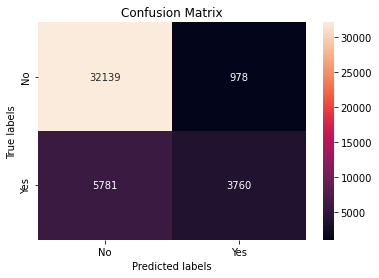

In [219]:
# Taking a look at the confusion matrix for our model
ax= plt.subplot()
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='g', ax=ax)

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(le.classes_); ax.yaxis.set_ticklabels(le.classes_)

In [210]:
# A quick report to see the preicision, recall and f1-score metrics of our model
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.97      0.90     33117
           1       0.79      0.39      0.53      9541

    accuracy                           0.84     42658
   macro avg       0.82      0.68      0.72     42658
weighted avg       0.84      0.84      0.82     42658



# 4.0 Storing Models

Now that we have trained our model, let's store it so that we can use it later in production.

This includes the labelencoder we used earlier.

In [222]:
# Using the pickle library to save our models
p.dump(le, open('../models/label_encoder.pickle', 'wb'))
p.dump(cv.best_estimator_, open('../models/random_forest_classifier.pickle', 'wb'))